In [61]:
import optuna
import pickle
import nltk
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB


from sklearn.pipeline import make_pipeline
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score

import optuna

from gensim.models import Word2Vec

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb  # Make sure to install xgboost if not already installed

In [50]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.8 MB/s eta 0:00:00


In [8]:
df=pd.read_csv('/content/spam-vs-ham-dataset .csv',encoding="ISO-8859-1")
df.head()

,Text,Label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


In [9]:
df.isnull().sum()

,0
Text,0
Label,0


In [10]:
df.duplicated().sum()

403

In [11]:
df.drop_duplicates(keep='first',inplace=True)

In [12]:
df.shape

(5171, 2)

In [13]:
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()
df['Label']=le.fit_transform(df['Label'])
df.head()

,Text,Label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


([<matplotlib.patches.Wedge at 0x7f56fbeba320>,
 [Text(-1.0145649212950327, 0.4250388458454174, 'ham'),
  Text(1.014564901397527, -0.4250388933406287, 'spam')],
 [Text(-0.5533990479791087, 0.23183937046113673, '87.37'),
  Text(0.5533990371259238, -0.23183939636761564, '12.63')])

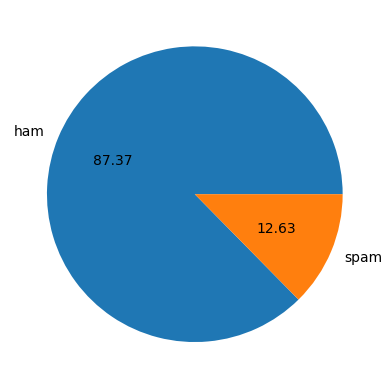

In [30]:
plt.pie(df['Label'].value_counts(),labels=['ham','spam'],autopct="%.02f")


In [31]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [32]:
df['num_chr']=df['Text'].apply(len)
df['num_words']=df['Text'].apply(lambda x:len(nltk.word_tokenize(x)))
df['num_sent']=df['Text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [33]:
df.sample(5)

,Text,Label,num_chr,num_words,num_sent
5557,Yeh. Indians was nice. Tho it did kane me off ...,0,153,43,6
2800,I've told him that i've returned it. That shou...,0,63,17,2
4223,Yo you around? A friend of mine's lookin to pi...,0,65,15,2
505,+123 Congratulations - in this week's competit...,1,170,32,3
2501,Remember to ask alex about his pizza,0,36,7,1


In [34]:
df.describe()

,Label,num_chr,num_words,num_sent
count,5171.000000,5171.000000,5171.000000,5171.000000
mean,0.126281,79.457552,18.590988,1.973893
std,0.332198,58.401504,13.383728,1.458880
min,0.000000,2.000000,1.000000,1.000000
25%,0.000000,36.000000,9.000000,1.000000
50%,0.000000,61.000000,15.000000,1.000000
75%,0.000000,119.000000,26.000000,2.000000
max,1.000000,910.000000,220.000000,38.000000


In [35]:
df[['num_chr','num_words','num_sent']].describe()

,num_chr,num_words,num_sent
count,5171.000000,5171.000000,5171.000000
mean,79.457552,18.590988,1.973893
std,58.401504,13.383728,1.458880
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,61.000000,15.000000,1.000000
75%,119.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [36]:
df[df['Label']==0][['num_chr','num_words','num_sent']].describe()

,num_chr,num_words,num_sent
count,4518.000000,4518.000000,4518.000000
mean,70.976538,17.265162,1.827579
std,56.610538,13.566409,1.394245
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,53.000000,13.000000,1.000000
75%,91.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [37]:
df[df['Label']==1][['num_chr','num_words','num_sent']].describe()

,num_chr,num_words,num_sent
count,653.000000,653.000000,653.000000
mean,138.136294,27.764165,2.986217
std,29.934972,6.988123,1.494815
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


<Axes: xlabel='num_chr', ylabel='Count'>

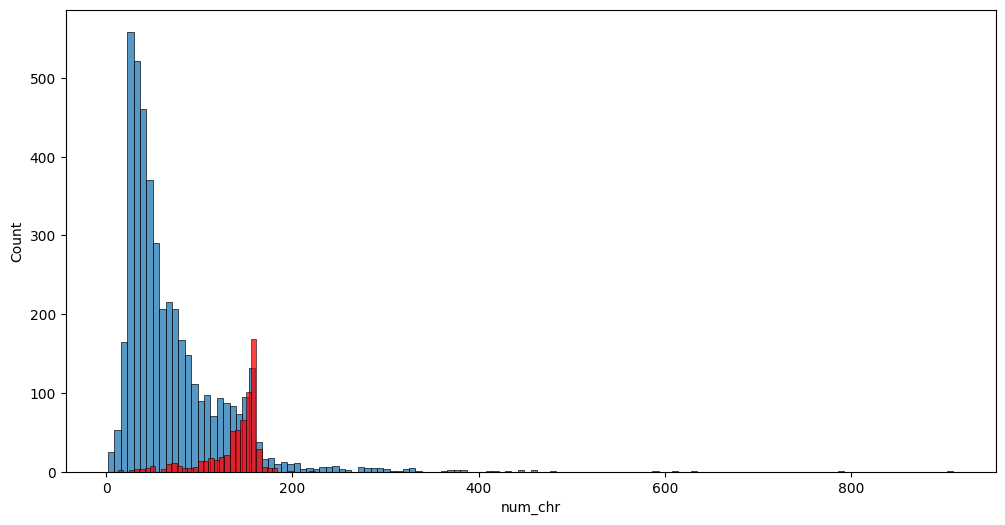

In [39]:
plt.figure(figsize=(12,6))

sns.histplot(df[df['Label']==0]['num_chr'])
sns.histplot(df[df['Label']==1]['num_chr'],color='red')
plt.savefig('./../Image/spam-ham-num_chr.jpg')

<Axes: xlabel='num_words', ylabel='Count'>

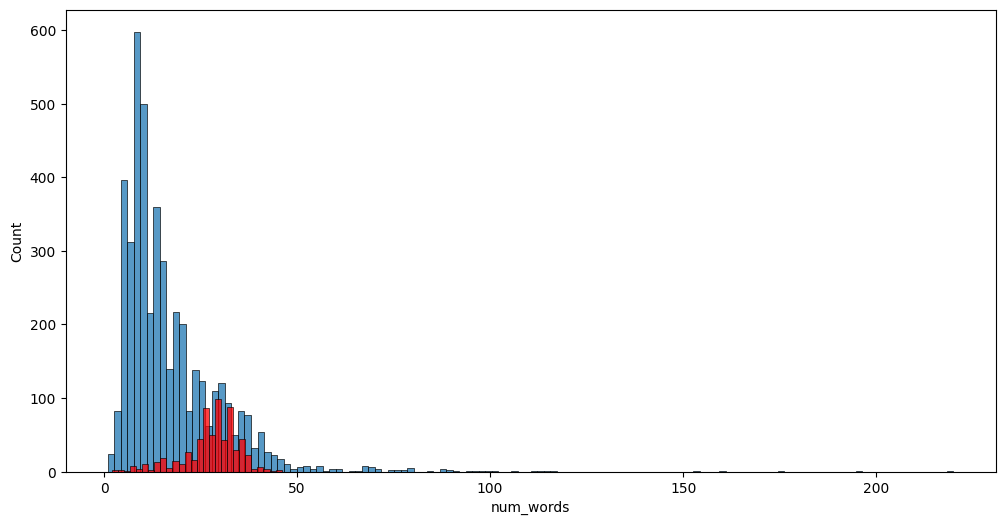

In [40]:
plt.figure(figsize=(12,6))

sns.histplot(df[df['Label']==0]['num_words'])
sns.histplot(df[df['Label']==1]['num_words'],color='red')
plt.savefig('./../Image/spam-ham-num_word.jpg')

<Axes: xlabel='num_sent', ylabel='Count'>

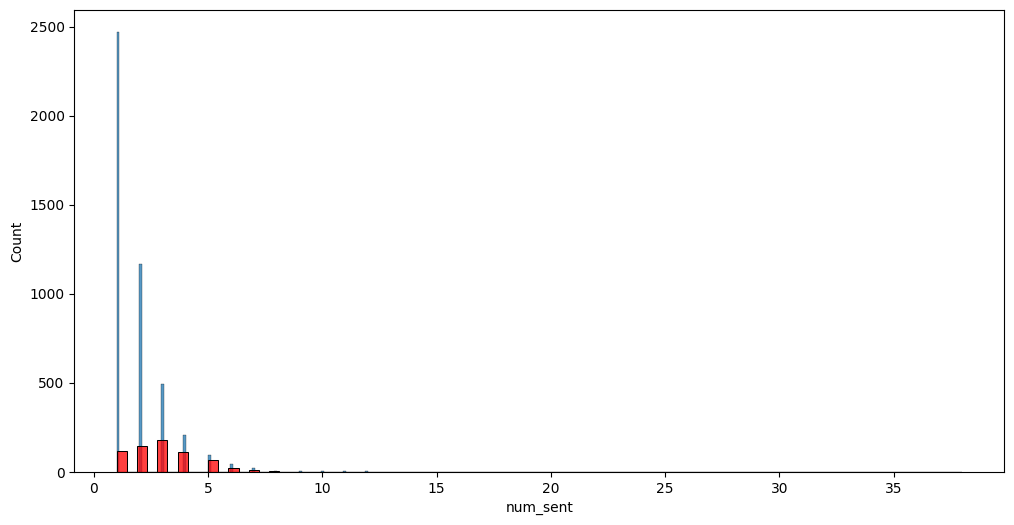

In [41]:
plt.figure(figsize=(12,6))

sns.histplot(df[df['Label']==0]['num_sent'])
sns.histplot(df[df['Label']==1]['num_sent'],color='red')
plt.savefig('./../Image/spam-ham-num_sent.jpg')

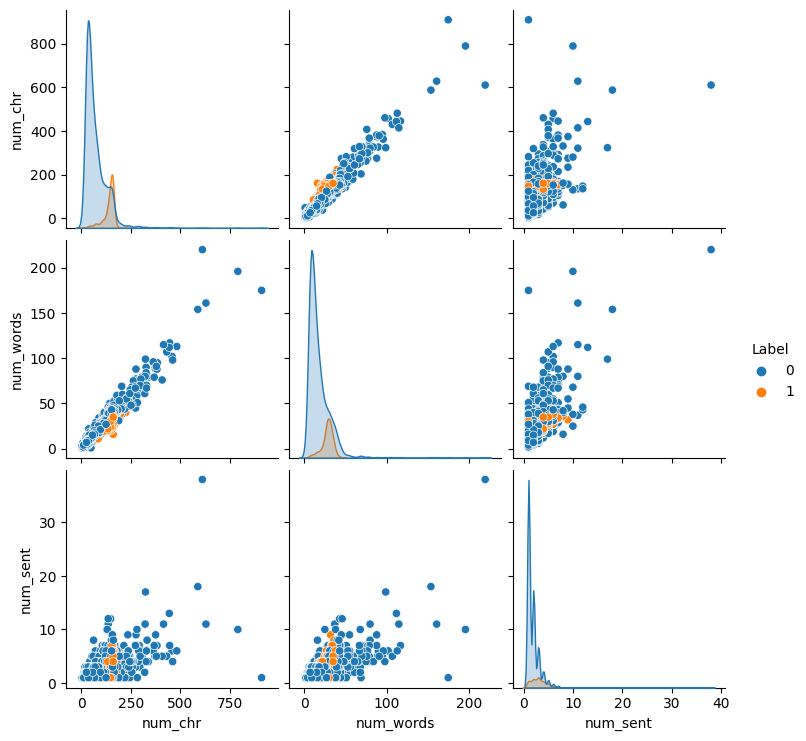

In [ ]:
sns.pairplot(df,hue='Label')
plt.savefig('./../Image/PairPlot_withHue.png',dpi=300)

In [42]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [43]:
from nltk.corpus import stopwords
import string

from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

In [53]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

# Make sure the necessary resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer and stopwords once globally to avoid doing it in every function call
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
punctuations = set(string.punctuation)

def transform_text(text):
    # Lowercase and tokenize
    text = nltk.word_tokenize(text.lower())

    # Filter tokens that are alphanumeric, not in stopwords, and not punctuation, while lemmatizing them
    transformed_text = [
        lemmatizer.lemmatize(word)
        for word in text
        if word.isalnum() and word not in stop_words and word not in punctuations
    ]

    return " ".join(transformed_text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [54]:


df['Transformer_text']=df['Text'].apply(transform_text)
df.head()

,Text,Label,num_chr,num_words,num_sent,Transformer_text
0,"Go until jurong point, crazy.. Available only ...",0,111,24,2,go jurong point crazy available bugis n great ...
1,Ok lar... Joking wif u oni...,0,29,8,2,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,37,2,free entry 2 wkly comp win fa cup final tkts 2...
3,U dun say so early hor... U c already then say...,0,49,13,1,u dun say early hor u c already say
4,"Nah I don't think he goes to usf, he lives aro...",0,61,15,1,nah think go usf life around though


In [62]:
preprocessed_text = df['Transformer_text']

In [63]:
## Train a Word2Vec model on the preprocessed data
sentences = [sentence.split() if isinstance(sentence, str) else [] for sentence in preprocessed_text]  # Tokenize the text, handle non-string values
word2vec_model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=1, workers=4, seed=42)

In [65]:
# Convert text to Word2Vec embeddings (average of word vectors for each sentence)
def vectorize_text(text, model):
    if isinstance(text, str):  # Check if the text is a string
        words = text.split()
        word_vectors = [model.wv[word] for word in words if word in model.wv]
        if len(word_vectors) > 0:
            return np.mean(word_vectors, axis=0)
        else:
            return np.zeros(model.vector_size)  # Return a zero vector if no word is in the vocabulary
    else:
        return np.zeros(model.vector_size)  # Return a zero vector if text is not a string

# Convert entire dataset to vectors
X = np.array([vectorize_text(text, word2vec_model) for text in preprocessed_text])
y = df['Label'].values  # Target variable


In [66]:
# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
def objective(trial):
    model_type = trial.suggest_categorical('model_type', [
        'BernoulliNB', 'LogisticRegression', 'RandomForest', 'SVC',
        'KNeighborsClassifier', 'GradientBoostingClassifier', 'AdaBoostClassifier', 'XGBoost'
    ])

    # Define models and hyperparameters to tune
    if model_type == 'BernoulliNB':
        alpha = trial.suggest_float('alpha', 1e-5, 1.0, log=True)
        model = BernoulliNB(alpha=alpha)

    elif model_type == 'LogisticRegression':
        C = trial.suggest_float('C', 1e-5, 1.0, log=True)
        model = LogisticRegression(C=C, max_iter=1000)

    elif model_type == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 10, 200)
        max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)

    elif model_type == 'SVC':
        C = trial.suggest_float('C', 1e-5, 1.0, log=True)
        kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])
        model = SVC(C=C, kernel=kernel)

    elif model_type == 'KNeighborsClassifier':
        n_neighbors = trial.suggest_int('n_neighbors', 1, 20)
        model = KNeighborsClassifier(n_neighbors=n_neighbors)

    elif model_type == 'GradientBoostingClassifier':
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0, log=True)
        model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate)

    elif model_type == 'AdaBoostClassifier':
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0, log=True)
        model = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate)

    elif model_type == 'XGBoost':
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0, log=True)
        max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
        model = xgb.XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, use_label_encoder=False, eval_metric='mlogloss')

    # Use cross-validation to evaluate model performance
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy')

    return 1 - scores.mean()  # Minimizing the error rate

# Optuna optimization process
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2024-10-04 11:46:42,871] A new study created in memory with name: no-name-59ba621e-6ee7-4258-91d5-81bfea60ad05
[I 2024-10-04 11:46:42,925] Trial 0 finished with value: 0.12475823509249429 and parameters: {'model_type': 'BernoulliNB', 'alpha': 2.737305409820249e-05}. Best is trial 0 with value: 0.12475823509249429.
[I 2024-10-04 11:46:43,057] Trial 1 finished with value: 0.12475823509249429 and parameters: {'model_type': 'LogisticRegression', 'C': 0.5855544341610596}. Best is trial 0 with value: 0.12475823509249429.
[I 2024-10-04 11:46:43,344] Trial 2 finished with value: 0.08124090257027705 and parameters: {'model_type': 'KNeighborsClassifier', 'n_neighbors': 4}. Best is trial 2 with value: 0.08124090257027705.
[I 2024-10-04 11:46:55,892] Trial 3 finished with value: 0.06818217698401596 and parameters: {'model_type': 'RandomForest', 'n_estimators': 171, 'max_depth': 23}. Best is trial 3 with value: 0.06818217698401596.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: Use

In [68]:
# Retrieve the best model from Optuna study
best_model_params = study.best_trial.params
best_model_type = best_model_params['model_type']

# Train the best model using the entire training data
if best_model_type == 'BernoulliNB':
    best_model = BernoulliNB(alpha=best_model_params['alpha'])
elif best_model_type == 'LogisticRegression':
    best_model = LogisticRegression(C=best_model_params['C'], max_iter=1000)
elif best_model_type == 'RandomForest':
    best_model = RandomForestClassifier(n_estimators=best_model_params['n_estimators'], max_depth=best_model_params['max_depth'])
elif best_model_type == 'SVC':
    best_model = SVC(C=best_model_params['C'], kernel=best_model_params['kernel'])
elif best_model_type == 'KNeighborsClassifier':
    best_model = KNeighborsClassifier(n_neighbors=best_model_params['n_neighbors'])
elif best_model_type == 'GradientBoostingClassifier':
    best_model = GradientBoostingClassifier(n_estimators=best_model_params['n_estimators'], learning_rate=best_model_params['learning_rate'])
elif best_model_type == 'AdaBoostClassifier':
    best_model = AdaBoostClassifier(n_estimators=best_model_params['n_estimators'], learning_rate=best_model_params['learning_rate'])
elif best_model_type == 'XGBoost':
    best_model = xgb.XGBClassifier(n_estimators=best_model_params['n_estimators'], learning_rate=best_model_params['learning_rate'], max_depth=best_model_params['max_depth'], use_label_encoder=False, eval_metric='mlogloss')

# Train the best model
best_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:53:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.24928047667141826, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=142, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [69]:
# Evaluate the model on the test data
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.9400966183574879


In [70]:

# Save the best model as a .pkl file
model_filename = 'best_model.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(best_model, f)

print(f"Best model saved as {model_filename}")

Best model saved as best_model.pkl


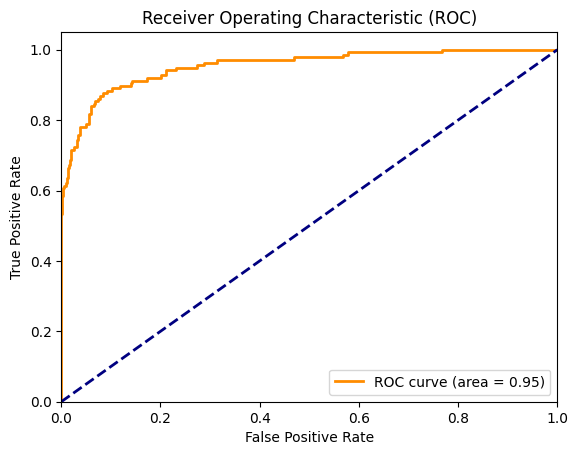

In [74]:


from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are already defined from your model evaluation
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probability of being class 1 (spam)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [76]:


from sklearn.metrics import confusion_matrix, classification_report, f1_score

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(report)


f1 = f1_score(y_test, y_pred)
print(f"\nF1-Score: {f1}")


Confusion Matrix:
[[885  13]
 [ 49  88]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       898
           1       0.87      0.64      0.74       137

    accuracy                           0.94      1035
   macro avg       0.91      0.81      0.85      1035
weighted avg       0.94      0.94      0.94      1035


F1-Score: 0.7394957983193278


In [73]:
import streamlit as st
from nltk.stem import WordNetLemmatizer
import pickle
import nltk
import string
from nltk.corpus import stopwords


lemmatizer = WordNetLemmatizer()

def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)

    y = []
    for i in text:
        if i.isalnum():
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:
        y.append(lemmatizer.lemmatize(i))


    return " ".join(y)


# Store the model in your file
# tfidf=pickle.load(open('vectorizer.pkl','rb'))
# model=pickle.load(open('bnb.pkl','rb'))

st.title('SMS Spam Classification')

sms_input=st.text_area("Enter the text")

if st.button('Predict'):
    transform_sms=transform_text(sms_input)

    vector_input=tfidf.transform([transform_sms])

    result=bnb.predict(vector_input)[0]

    if result==1:
        st.title("SMS is Spam")

    else:
        st.title("SMS is not Spam")

2024-10-04 11:55:11.061 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-04 11:55:11.194 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2024-10-04 11:55:11.196 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-04 11:55:11.199 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-04 11:55:11.202 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-04 11:55:11.204 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-04 11:55:11.206 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-04 11:55:11.207 Session state does not 